In [1]:
import numpy as np
import pandas as pd
import bokeh.plotting as bp
import bokeh as bk 
bp.output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [2]:
#Se lee la señal pre-procesada
data_set = pd.read_csv("./data/TrueFX/EUR-USD/datos_procesados_EURUSD-2017-07.csv")

In [3]:
data_set.head()

,date,bid,ask
0,2017-07-03 00:00:10,1.14183,1.14211
1,2017-07-03 00:00:20,1.14163,1.14211
2,2017-07-03 00:00:30,1.14164,1.14206
3,2017-07-03 00:00:50,1.14164,1.14206
4,2017-07-03 00:01:00,1.14164,1.14208


In [4]:
data_set = data_set.set_index(pd.to_datetime(data_set.iloc[:,0])) #Se indexan los datos por su fecha y hora
data_set = data_set.drop(['date'],axis = 1) #se elimina la columna date
data_set = data_set.drop(data_set['2017-07-30'].index)

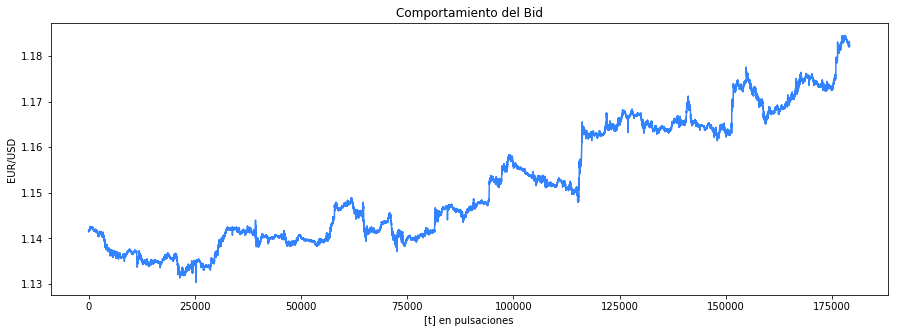

In [5]:
plt.figure(figsize=(15,5))
plt.title('Comportamiento del Bid')
plt.xlabel('[t] en pulsaciones')
plt.ylabel('EUR/USD')
plt.plot(np.arange(data_set.shape[0]), data_set.iloc[:,0], alpha =1, color='#3383FF');

In [6]:
dates = pd.unique(data_set.index.date) #se sacan los días de la señal para separar por bussines day

In [7]:
print('                   Bussines day - year, month, day')
print()
print(dates)

                   Bussines day - year, month, day

[datetime.date(2017, 7, 3) datetime.date(2017, 7, 4)
 datetime.date(2017, 7, 5) datetime.date(2017, 7, 6)
 datetime.date(2017, 7, 7) datetime.date(2017, 7, 10)
 datetime.date(2017, 7, 11) datetime.date(2017, 7, 12)
 datetime.date(2017, 7, 13) datetime.date(2017, 7, 14)
 datetime.date(2017, 7, 17) datetime.date(2017, 7, 18)
 datetime.date(2017, 7, 19) datetime.date(2017, 7, 20)
 datetime.date(2017, 7, 21) datetime.date(2017, 7, 24)
 datetime.date(2017, 7, 25) datetime.date(2017, 7, 26)
 datetime.date(2017, 7, 27) datetime.date(2017, 7, 28)
 datetime.date(2017, 7, 31) datetime.date(2017, 8, 1)]


##### Creación del generador para pasar a cross_val_score como "cv"

In [8]:
def v_split(X, n_bdtrain, n_bdtest, mday):
    
    """
    X, dataframe, se necesita el indice de este para separar por días.
    n_bdtrain, número de bussines day utilizados para train
    n_bdtest, número de bussines day utilizados para test
    mday, días a correr para cada validación
    
    """
    from datetime import date
    start_day = 0
    
    "Divide el data set según días de train, test y cuanto se va moviendo"
    bussines_day = []
    dates = pd.unique(X.index.date) #saco las fechas para luego tomar solo año-mes-día
    
    for i in dates: bussines_day.append(date.__format__(i,'%Y-%m-%d')) #lista de los bussines day
   
    intervals = []
    count = 0
    for i in bussines_day:
        f = len(X[i])-1 +count
        intervals.append([count,f])
        count = f+1

    for i in range(len(intervals)-n_bdtrain):
        yield(np.arange(intervals[start_day:start_day+n_bdtrain][0][0],
                        intervals[start_day:start_day+n_bdtrain][n_bdtrain-1][1]+1),
             np.arange(intervals[n_bdtrain+start_day:n_bdtrain+start_day+n_bdtest][0][0],
              intervals[n_bdtrain+start_day:n_bdtrain+start_day+n_bdtest][n_bdtest-1][1]+1))
        
        start_day += mday
        if start_day+n_bdtest > len(intervals)-n_bdtrain:
            break

In [9]:
data_set.shape

(179116, 2)

In [10]:
for i in v_split(data_set,4,1,1):
    print (i)

(array([    0,     1,     2, ..., 33801, 33802, 33803]), array([33804, 33805, 33806, ..., 42269, 42270, 42271]))
(array([ 8423,  8424,  8425, ..., 42269, 42270, 42271]), array([42272, 42273, 42274, ..., 50650, 50651, 50652]))
(array([16869, 16870, 16871, ..., 50650, 50651, 50652]), array([50653, 50654, 50655, ..., 59071, 59072, 59073]))
(array([25341, 25342, 25343, ..., 59071, 59072, 59073]), array([59074, 59075, 59076, ..., 67569, 67570, 67571]))
(array([33804, 33805, 33806, ..., 67569, 67570, 67571]), array([67572, 67573, 67574, ..., 76030, 76031, 76032]))
(array([42272, 42273, 42274, ..., 76030, 76031, 76032]), array([76033, 76034, 76035, ..., 84465, 84466, 84467]))
(array([50653, 50654, 50655, ..., 84465, 84466, 84467]), array([84468, 84469, 84470, ..., 92875, 92876, 92877]))
(array([59074, 59075, 59076, ..., 92875, 92876, 92877]), array([ 92878,  92879,  92880, ..., 101430, 101431, 101432]))
(array([ 67572,  67573,  67574, ..., 101430, 101431, 101432]), array([101433, 101434, 1014

In [11]:
def build_dataset(signal, window, binary_target=False, delete_constant_values=True, PNL=False):
    """
    función para construir un data set
    window: tamaño de la ventana a utilizar para construir el dataset
    signal: dataframe
    binary_target: si desea clasificar, este arroja 2 si el valor se mantiene,
    1 si el valor sube y 0 si este baja.
    delete_constant_values: default: True, elimina los valores que se mantienen
    
    retorna:
    X: dataset, con columna de PNL si así se especifica(default: False)
    y: target
    bt: binary target, default: False
    """
    result = []
    binary = [] #para la columna objetivo binaria
    pnl_col = [] #almacenar el PNL
    indx = signal.index[window+1:] #se toman los indicen que quedarán al final
    for i in range(len(signal) - window-1):
        
        if delete_constant_values == True:
            if signal[i+window] != signal[i+window-1]:

                result.append(signal[i: i + window+1])
                if PNL == True: pnl_col.append(signal[i+window]-signal[i+window-1])
                
                if binary_target == True:
                    if signal[i+window] < signal[i+window-1]: binary.append(0) # 0 si baja
                    if signal[i+window] > signal[i+window-1]: binary.append(1) # 1 si sube
                        
            else: indx = indx.delete(len(result))
        else:

            result.append(signal[i: i + window+1])
            if PNL == True: pnl_col.append(signal[i+window]-signal[i+window-1])
            
        if binary_target == True and delete_constant_values == False:
            if signal[i+window] == signal[i+window-1]: binary.append(2) # 2 si se mantiene
            if signal[i+window] < signal[i+window-1]: binary.append(0) # 1 si baja
            if signal[i+window] > signal[i+window-1]: binary.append(1) # 0 si sube
    
    data = pd.DataFrame(np.array(result), index=indx)
    y = np.array(data.iloc[:,window])
    data = data.drop(window,axis=1)
    if PNL == True: data['PNL'] = pnl_col
    if binary_target == True: return data, y, np.array(binary)
    else: return data, y

In [12]:
#X = pd.DataFrame(np.random.random((20,1)), index =pd.date_range('2017-01-01','2017-01-20'))
#X.head()

In [13]:
#se crea el dataset con una ventada de tamaño window
window = 10
X, y_reg, bt = build_dataset(data_set.iloc[:,0], window, binary_target=True, delete_constant_values=True, PNL=True)

In [14]:
X.shape, bt.shape, y_reg.shape

((146086, 11), (146086,), (146086,))

In [15]:
print(y_reg[:5])
print(bt[:5])

[ 1.14156  1.14164  1.14163  1.14143  1.14163]
[0 1 0 0 1]


In [16]:
X.head()

,0,1,2,3,4,5,6,7,8,9,PNL
date,,,,,,,,,,,
2017-07-03 00:02:20,1.14163,1.14164,1.14164,1.14164,1.14164,1.14163,1.14156,1.14164,1.14164,1.14164,-0.00008
2017-07-03 00:02:30,1.14164,1.14164,1.14164,1.14164,1.14163,1.14156,1.14164,1.14164,1.14164,1.14156,0.00008
2017-07-03 00:02:40,1.14164,1.14164,1.14164,1.14163,1.14156,1.14164,1.14164,1.14164,1.14156,1.14164,-0.00001
2017-07-03 00:02:50,1.14164,1.14164,1.14163,1.14156,1.14164,1.14164,1.14164,1.14156,1.14164,1.14163,-0.00020
2017-07-03 00:03:10,1.14164,1.14163,1.14156,1.14164,1.14164,1.14164,1.14156,1.14164,1.14163,1.14143,0.00020


In [17]:
X.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'PNL'], dtype='object')

In [18]:
# data_set_w[[1,'Target']]

In [18]:
from sklearn.model_selection import cross_val_score

y = bt

from sklearn.neighbors import KNeighborsClassifier

n_bdtrain = 4 #número de dias con los que se entrena
n_bdtest = 1  #número de días con los que se hace el test
move_day = 1  #número de días que se van corriendo

vs = v_split(X,n_bdtrain,n_bdtest,move_day)
k = KNeighborsClassifier()

for train_index, test_index in vs:
    print ('train = ',train_index, 'test = ',test_index)
print()
result = cross_val_score(k, X, y, cv=v_split(X, n_bdtrain, n_bdtest, move_day))

print(result)
print()
print('score avg = ', np.mean(result))
print('score std = ', np.std(result))

train =  [    0     1     2 ..., 27012 27013 27014] test =  [27015 27016 27017 ..., 34025 34026 34027]
train =  [ 6734  6735  6736 ..., 34025 34026 34027] test =  [34028 34029 34030 ..., 40560 40561 40562]
train =  [13258 13259 13260 ..., 40560 40561 40562] test =  [40563 40564 40565 ..., 47247 47248 47249]
train =  [20131 20132 20133 ..., 47247 47248 47249] test =  [47250 47251 47252 ..., 54243 54244 54245]
train =  [27015 27016 27017 ..., 54243 54244 54245] test =  [54246 54247 54248 ..., 61138 61139 61140]
train =  [34028 34029 34030 ..., 61138 61139 61140] test =  [61141 61142 61143 ..., 67858 67859 67860]
train =  [40563 40564 40565 ..., 67858 67859 67860] test =  [67861 67862 67863 ..., 74489 74490 74491]
train =  [47250 47251 47252 ..., 74489 74490 74491] test =  [74492 74493 74494 ..., 81690 81691 81692]
train =  [54246 54247 54248 ..., 81690 81691 81692] test =  [81693 81694 81695 ..., 88435 88436 88437]
train =  [61141 61142 61143 ..., 88435 88436 88437] test =  [88438 88439 

In [19]:
class PNLEstimatorWrapper:
    
    def __init__(self, estimator, PNL_column, exclude_PNL_column_from_training=True):
        self.estimator = estimator
        self.PNL_column = PNL_column
        self.exclude_PNL_column_from_training = exclude_PNL_column_from_training
        
    def fit(self, X, y):
        assert self.PNL_column in X.columns, "column "+self.PNL_column+" not in X dataframe"
        if self.exclude_PNL_column_from_training:
            X = X[[col for col in X.columns if col!=self.PNL_column]]
        self.estimator.fit(X,y)
        
    def predict(self, X):
        assert self.PNL_column in X.columns, "column "+self.PNL_column+" not in X dataframe"
        if self.exclude_PNL_column_from_training:
            X = X[[col for col in X.columns if col!=self.PNL_column]]
        return self.estimator.predict(X)
    
    def get_params(self, deep=False):
        return {"PNL_column": self.PNL_column,
                "exclude_PNL_column_from_training": self.exclude_PNL_column_from_training,
                "estimator": self.estimator}

##### creación de la función de "scoring"

In [20]:
def PNL_score(estimator, X, y):
    """
    efdf
    
    
    """
    PNL = X[estimator.PNL_column]
    r = sum((y==estimator.predict(X))*abs(PNL) - (y!=estimator.predict(X))*abs(PNL))
    
    return r

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column='PNL')
result_GNB = cross_val_score(est_GNB, X, y, cv=v_split(X,4,1,1),scoring=PNL_score)
print ('average: ',np.mean(result_GNB))
print ('PNL', result_GNB)

average:  -0.00191444444444
PNL [ 0.00235  0.00019 -0.00881  0.0053   0.00019  0.00162 -0.00116 -0.00749
  0.00404 -0.0045  -0.0034   0.0023  -0.0007  -0.00865 -0.00419 -0.00398
 -0.00946  0.00189]


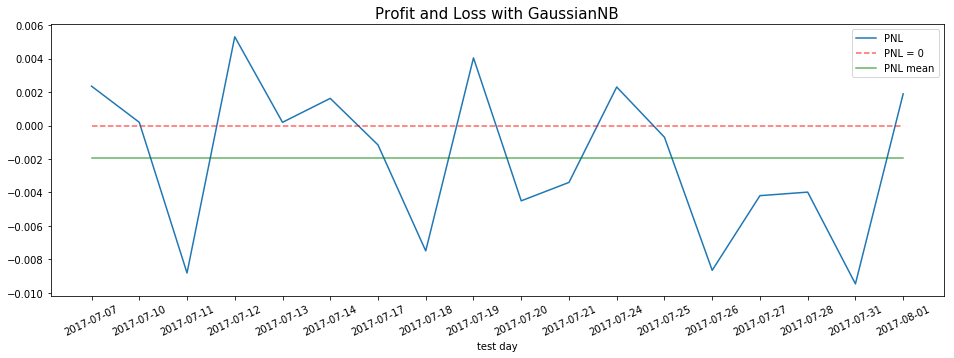

In [22]:
plt.figure(figsize=(16,5))
plt.title('Profit and Loss with GaussianNB', size=15)
plt.plot(range(len(result_GNB)), result_GNB, label='PNL')
plt.plot(range(len(result_GNB)), np.zeros(len(result_GNB)),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_GNB)), np.ones(len(result_GNB))*np.mean(result_GNB), color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_GNB)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

In [26]:
from sklearn.tree import DecisionTreeClassifier

#est = PNLEstimatorWrapper(DecisionTreeClassifier(random_state=0), PNL_column='PNL')
est = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column='PNL')
result_DTC = cross_val_score(est, X, y, cv=v_split(X,4,1,1), scoring=PNL_score)
print ('average: ',np.mean(result_DTC))
print ('PNL', result_DTC)

average:  0.00274333333333
PNL [ 0.00639  0.00129  0.00609 -0.00664 -0.00603  0.00328  0.0064  -0.00735
  0.00658  0.00186  0.00092  0.00588 -0.00258  0.01249  0.00229  0.00246
  0.01514  0.00091]


In [27]:
est.fit(X,y)
sum(est.predict(X))

71430

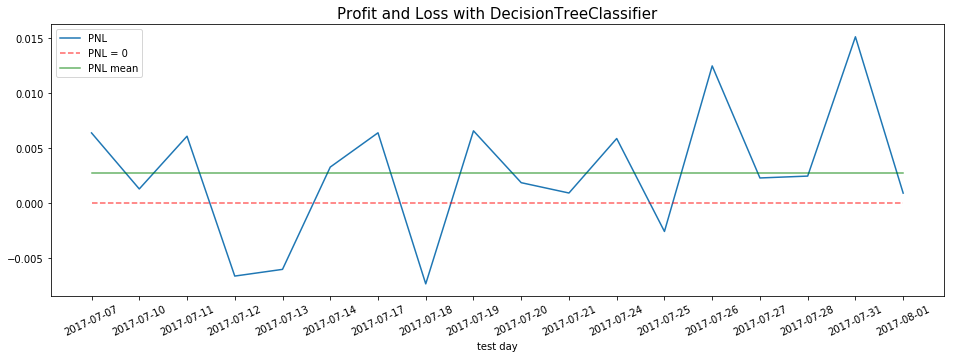

In [28]:
plt.figure(figsize=(16,5))
plt.title('Profit and Loss with DecisionTreeClassifier', size=15)
plt.plot(range(len(result_DTC)), result_DTC, label='PNL')
plt.plot(range(len(result_DTC)), np.zeros(len(result_DTC)),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_DTC)), np.ones(len(result_DTC))*np.mean(result_DTC), color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_DTC)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

In [30]:
from sklearn.ensemble import RandomForestClassifier

est = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column='PNL')
result_RFC = cross_val_score(est, X, y, cv=v_split(X,4,1,1), scoring=PNL_score)
print ('average: ',np.mean(result_RFC))
print ('PNL', result_RFC)

average:  0.00121
PNL [-0.00017  0.01025  0.00057 -0.00034  0.00709  0.00478  0.00752  0.00609
  0.00352 -0.0095   0.00206  0.00016 -0.00116 -0.00227  0.00047 -0.00632
 -0.00202  0.00105]


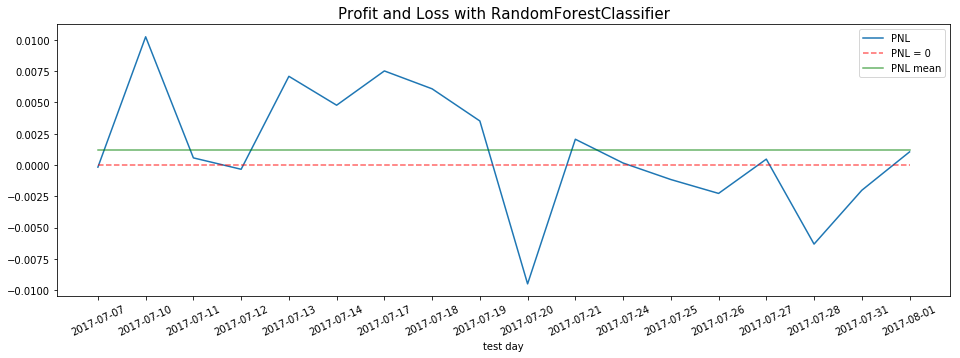

In [31]:
plt.figure(figsize=(16,5))
plt.title('Profit and Loss with RandomForestClassifier', size=15)
plt.plot(range(len(result_RFC)), result_RFC, label='PNL')
plt.plot(range(len(result_RFC)), np.zeros(len(result_RFC)),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_RFC)), np.ones(len(result_RFC))*np.mean(result_RFC), color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_RFC)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

In [32]:
from sklearn.neighbors import KNeighborsClassifier

est = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=5, n_jobs=3), PNL_column='PNL')
result_KNC = cross_val_score(est, X, y, cv=v_split(X,4,1,1), scoring=PNL_score)
print ('average: ',np.mean(result_KNC))
print ('PNL', result_KNC)

average:  0.00263111111111
PNL [ 0.00673  0.00389 -0.00121 -0.00544  0.00807  0.00452 -0.0011  -0.00193
  0.00294 -0.00548 -0.00238  0.01544 -0.0012   0.01651  0.00859  0.00036
 -0.00232  0.00137]


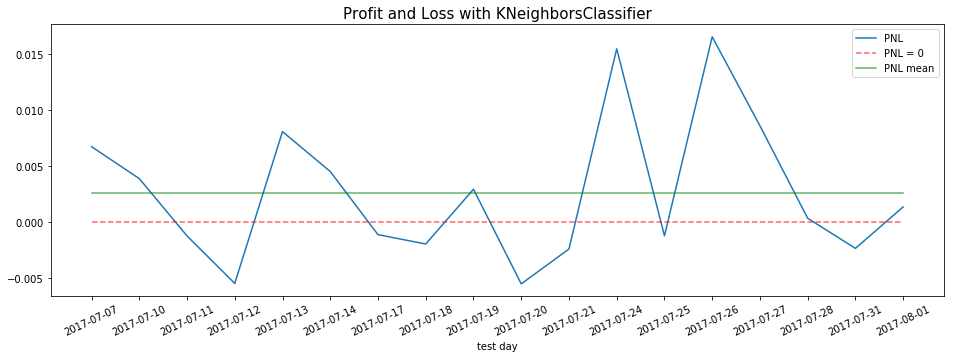

In [33]:
plt.figure(figsize=(16,5))
plt.title('Profit and Loss with KNeighborsClassifier', size=15)
plt.plot(range(len(result_KNC)), result_KNC, label='PNL')
plt.plot(range(len(result_KNC)), np.zeros(len(result_KNC)),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_KNC)), np.ones(len(result_KNC))*np.mean(result_KNC), color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_KNC)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

In [34]:
X.head()

,0,1,2,3,4,5,6,7,8,9,PNL
date,,,,,,,,,,,
2017-07-03 00:02:20,1.14163,1.14164,1.14164,1.14164,1.14164,1.14163,1.14156,1.14164,1.14164,1.14164,-0.00008
2017-07-03 00:02:30,1.14164,1.14164,1.14164,1.14164,1.14163,1.14156,1.14164,1.14164,1.14164,1.14156,0.00008
2017-07-03 00:02:40,1.14164,1.14164,1.14164,1.14163,1.14156,1.14164,1.14164,1.14164,1.14156,1.14164,-0.00001
2017-07-03 00:02:50,1.14164,1.14164,1.14163,1.14156,1.14164,1.14164,1.14164,1.14156,1.14164,1.14163,-0.00020
2017-07-03 00:03:10,1.14164,1.14163,1.14156,1.14164,1.14164,1.14164,1.14156,1.14164,1.14163,1.14143,0.00020


##### Probando modificando la ventana
Añadiendo datos a la ventana, como el min de los datos, el max, la media...

In [50]:
def data_processing(data, PNL_column, n_min=True,n_max=True,n_mean=True,n_std=True):
    """
    data: Dataframe
    PNL_column: columna a omitir para los cálculos
    n_min: columna de los números menores de cada fila
    n_max: columna de los números mayores de cada fila
    n_mean: columna de las medias de cada fila
    n_std: columna de desviación estándar de cada fila
    
    """
    assert (PNL_column) in data, "Error, column dataframe"
    #assert 'min' in data, "Error, column 'min' already in dataframe"
    #assert 'max' in data, "Error, column 'max' already in dataframe"
    #assert 'mean' in data, "Error, column 'mean' already in dataframe"
    #assert 'std' in data, "Error, column 'std' already in dataframe"
    c_min, c_max, c_mean, c_std= [], [], [], []
    c_PNL = data[PNL_column]
    data = data.drop(PNL_column,axis=1)
    
    for index in range(len(data)):
        c_min.append(min(data.iloc[index]))
        c_max.append(max(data.iloc[index]))
        c_mean.append(np.mean(data.iloc[index]))
        c_std.append(np.std(data.iloc[index]))
    
    if n_min: data.insert(loc=data.shape[1],column='min',value=c_min)
    if n_max: data.insert(loc=data.shape[1],column='max',value=c_max)
    if n_mean: data.insert(loc=data.shape[1],column='mean',value=c_mean)
    if n_std: data.insert(loc=data.shape[1],column='std',value=c_std)
    data.insert(loc=data.shape[1],value=c_PNL,column=PNL_column)
    return data

In [51]:
X.head()

,0,1,2,3,4,5,6,7,8,9,PNL
date,,,,,,,,,,,
2017-07-03 00:02:10,1.141614,1.141625,1.141626,1.141640,1.141640,1.141625,1.141630,1.141545,1.141627,1.14164,-0.000040
2017-07-03 00:02:30,1.141626,1.141640,1.141640,1.141625,1.141630,1.141545,1.141627,1.141640,1.141600,1.14160,0.000040
2017-07-03 00:02:40,1.141640,1.141640,1.141625,1.141630,1.141545,1.141627,1.141640,1.141600,1.141600,1.14164,-0.000010
2017-07-03 00:02:50,1.141640,1.141625,1.141630,1.141545,1.141627,1.141640,1.141600,1.141600,1.141640,1.14163,-0.000200
2017-07-03 00:03:10,1.141625,1.141630,1.141545,1.141627,1.141640,1.141600,1.141600,1.141640,1.141630,1.14143,0.000197


In [52]:
X = data_processing(data=X,PNL_column='PNL',n_std=False)

In [53]:
X.head()

,0,1,2,3,4,5,6,7,8,9,min,max,mean,PNL
date,,,,,,,,,,,,,,
2017-07-03 00:02:10,1.141614,1.141625,1.141626,1.141640,1.141640,1.141625,1.141630,1.141545,1.141627,1.14164,1.141545,1.14164,1.141621,-0.000040
2017-07-03 00:02:30,1.141626,1.141640,1.141640,1.141625,1.141630,1.141545,1.141627,1.141640,1.141600,1.14160,1.141545,1.14164,1.141617,0.000040
2017-07-03 00:02:40,1.141640,1.141640,1.141625,1.141630,1.141545,1.141627,1.141640,1.141600,1.141600,1.14164,1.141545,1.14164,1.141619,-0.000010
2017-07-03 00:02:50,1.141640,1.141625,1.141630,1.141545,1.141627,1.141640,1.141600,1.141600,1.141640,1.14163,1.141545,1.14164,1.141618,-0.000200
2017-07-03 00:03:10,1.141625,1.141630,1.141545,1.141627,1.141640,1.141600,1.141600,1.141640,1.141630,1.14143,1.141430,1.14164,1.141597,0.000197


average:  0.00224362176164
PNL [ 0.00578224 -0.00535676  0.00541746 -0.00569097  0.00829994  0.00596492
  0.00613921  0.00623037  0.00311773 -0.01051242 -0.00194793  0.00640207
 -0.00056357  0.00889243  0.00283303  0.00228074  0.00085309]


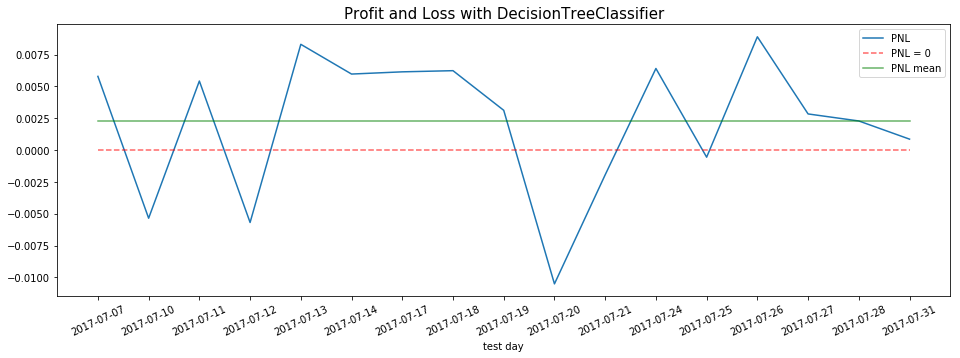

In [54]:
from sklearn.tree import DecisionTreeClassifier

#est = PNLEstimatorWrapper(DecisionTreeClassifier(random_state=0), PNL_column='PNL')
est = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column='PNL')
result = cross_val_score(est, X, y, cv=v_split(X,4,1,1), scoring=PNL_score)
print ('average: ',np.mean(result))
print ('PNL', result)

plt.figure(figsize=(16,5))
plt.title('Profit and Loss with DecisionTreeClassifier', size=15)
plt.plot(range(len(result)), result, label='PNL')
plt.plot(range(len(result)), np.zeros(len(result)),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result)), np.ones(len(result))*np.mean(result), color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

average:  0.0012328030179
PNL [-0.0013073  -0.00182861 -0.00496696  0.00786889  0.00198472  0.00208024
 -0.00185872  0.00544589  0.00394089 -0.00545957 -0.00290608 -0.00021916
  0.00217149  0.00797755  0.00521828  0.0113476  -0.00853151]


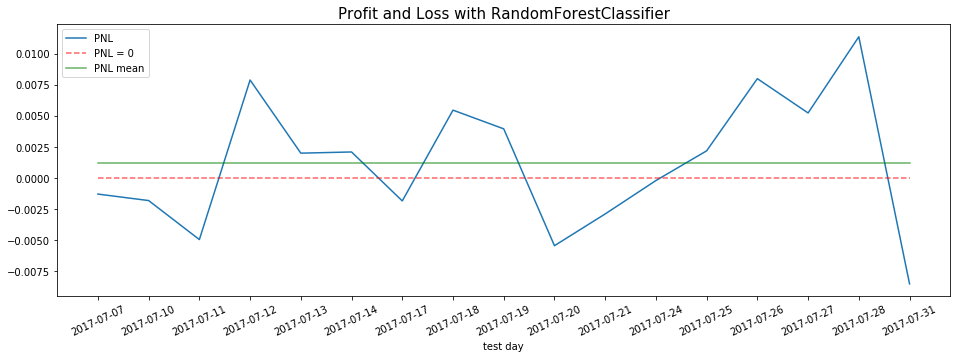

In [55]:
from sklearn.ensemble import RandomForestClassifier

est = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column='PNL')
result = cross_val_score(est, X, y, cv=v_split(X,4,1,1), scoring=PNL_score)
print ('average: ',np.mean(result))
print ('PNL', result)

plt.figure(figsize=(16,5))
plt.title('Profit and Loss with RandomForestClassifier', size=15)
plt.plot(range(len(result)), result, label='PNL')
plt.plot(range(len(result)), np.zeros(len(result)),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result)), np.ones(len(result))*np.mean(result), color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

In [57]:
from sklearn.ensemble import RandomForestClassifier

est = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column='PNL')
result = cross_val_score(est, X.drop('mean',axis=1), y, cv=v_split(X,4,1,1), scoring=PNL_score)
print ('average: ',np.mean(result))
print ('PNL', result)

average:  0.00445925698041
PNL [  3.26559331e-03   4.35282994e-03   1.40259768e-03   1.67640460e-03
   1.01231940e-02   3.97380829e-03  -2.28172498e-03   8.90237055e-03
   4.85110262e-03  -1.21810511e-03  -2.28550209e-03   1.25148485e-02
   8.75202719e-03   1.00902885e-02   5.68453400e-03   6.07757636e-03
  -7.44747669e-05]


In [58]:
from sklearn.ensemble import RandomForestClassifier

est = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column='PNL')
result = cross_val_score(est, X.drop('max',axis=1), y, cv=v_split(X,4,1,1), scoring=PNL_score)
print ('average: ',np.mean(result))
print ('PNL', result)

average:  0.0041858789148
PNL [ 0.01205575  0.00200904 -0.00132917 -0.00483946  0.00689313  0.01335276
  0.00457953  0.0047679   0.00804108 -0.00605827 -0.00085303  0.00590993
  0.00703418  0.01559532  0.00559758  0.00274726 -0.00434357]


In [59]:
from sklearn.ensemble import RandomForestClassifier

est = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column='PNL')
result = cross_val_score(est, X.drop('min',axis=1), y, cv=v_split(X,4,1,1), scoring=PNL_score)
print ('average: ',np.mean(result))
print ('PNL', result)

average:  0.00386647477625
PNL [ 0.00921686  0.00555191 -0.00153464 -0.00158789  0.00228499  0.00415142
  0.00392829  0.00670066  0.01522889 -0.00501378 -0.00123544  0.00714911
  0.00627896  0.00372862  0.00359522  0.00941964 -0.00213275]


commission of FxPro https://www.fxpro.co.uk/trading/calculators/ctrader-commission#

commission = invest_size * 0,00009USD * (EUR/USD)current

In [69]:
data_set.iloc[4:6]

,bid,ask
date,,
2017-07-03 00:01:00,1.141640,1.14208
2017-07-03 00:01:10,1.141625,1.14206


In [74]:
bid_b = 1.141640
ask_b = 1.14208
spreed_b = ask_b-bid_b

bid_a = 1.141625
ask_a = 1.14206

In [78]:
spreed_b

0.00043999999999999595

In [77]:
1000*abs(bid_b-bid_a) 

0.015000000000098268

#### Probando RNN

In [120]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

In [121]:
X_3d = (np.array(X)).reshape(X.shape[0],X.shape[1],1)[:,:-1]
PNL = X_3d[:,-1]
y_3d = bt.reshape(bt.shape[0],1)

print('Estructura de los datos')
print('X: ',X_3d.shape)
print('y: ',y_3d.shape)
print("PNL: ",PNL.shape)

Estructura de los datos
X:  (174945, 10, 1)
y:  (174945, 1)
PNL:  (174945, 1)


#### probar utilizando clasificación..

In [122]:
model = Sequential()
model.add(Dense(1, input_shape=(10,1)))
model.add(LSTM(units=128,return_sequences=True, activation="sigmoid"))
model.add(LSTM(units=64, activation="sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["accuracy"])

In [123]:
y_reg

array([ 1.1416    ,  1.14164   ,  1.14163   , ...,  1.18410367,
        1.18407191,  1.1841    ])

In [126]:
model.fit(X_3d[:130000,:,:], y_reg.reshape(y_reg.shape[0],1)[:130000], epochs=5)
#model.fit(X_3d[:130000,:,:], y_3d[:130000,:], epochs=1)

Epoch 1/5
130000/130000 [==============================] - 134s - loss: -2.1644 - acc: 0.0000e+00   
Epoch 2/5
130000/130000 [==============================] - 133s - loss: -2.3213 - acc: 0.0000e+00   
Epoch 3/5
130000/130000 [==============================] - 133s - loss: -2.3213 - acc: 0.0000e+00   
Epoch 4/5
130000/130000 [==============================] - 133s - loss: -2.3213 - acc: 0.0000e+00    ETA: 0s - loss: -2.3213 - acc: 0.0000e+
Epoch 5/5
130000/130000 [==============================] - 134s - loss: -2.3213 - acc: 0.0000e+00    ETA: 0s - los


In [127]:
score = model.evaluate(X_3d[:130000],y_3d[:130000])

129952/130000 [============================>.] - ETA: 0s

In [49]:
r = model.predict_classes(X_3d[130000:])

44416/44945 [============================>.] - ETA: 0s